# This is just a playground for me 

In [1]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1;
    X_locations = np.array(X_locations)
    Y_locations = np.array(Y_locations)
    Z_locations = np.array(Z_locations) 
    
    X_locs_1, X_locs_2 = X_locations[:21], X_locations[21:]
    Y_locs_1, Y_locs_2 = Y_locations[:21], Y_locations[21:]
    Z_locs_1, Z_locs_2 = Z_locations[:21], Z_locations[21:]
    locations = np.array([locs[np.nonzero(locs)].mean() for locs in [X_locs_1, X_locs_2, Y_locs_1, Y_locs_2, Z_locs_1, Z_locs_2] ])
    hands.close()
    return np.nan_to_num(locations)


def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 3))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations) 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [2]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('mean_point_folds'): 
    with open(f"mean_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)
X = np.nan_to_num(X)

In [51]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [37]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [19]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 65


In [38]:
def make_model(): 
    model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 6)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

Epoch 1/75
3/3 [==============================] - 2s 430ms/step - loss: 0.7150 - accuracy: 0.4625 - precision_133: 0.4675 - recall_133: 0.9474 - val_loss: 0.6853 - val_accuracy: 0.6500 - val_precision_133: 0.7273 - val_recall_133: 0.6667
Epoch 2/75
3/3 [==============================] - 2s 439ms/step - loss: 0.6912 - accuracy: 0.5375 - precision_133: 0.5143 - recall_133: 0.4737 - val_loss: 0.7021 - val_accuracy: 0.4000 - val_precision_133: 0.0000e+00 - val_recall_133: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 465ms/step - loss: 0.6851 - accuracy: 0.5000 - precision_133: 0.0000e+00 - recall_133: 0.0000e+00 - val_loss: 0.6873 - val_accuracy: 0.4500 - val_precision_133: 1.0000 - val_recall_133: 0.0833
Epoch 4/75
3/3 [==============================] - 1s 445ms/step - loss: 0.6640 - accuracy: 0.5625 - precision_133: 0.8000 - recall_133: 0.1053 - val_loss: 0.6402 - val_accuracy: 0.8000 - val_precision_133: 0.9000 - val_recall_133: 0.7500
Epoch 5/75
3/3 [================

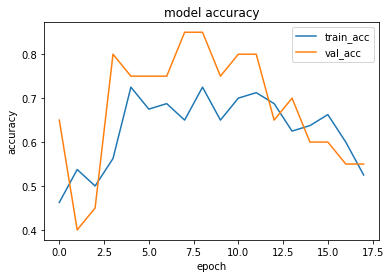

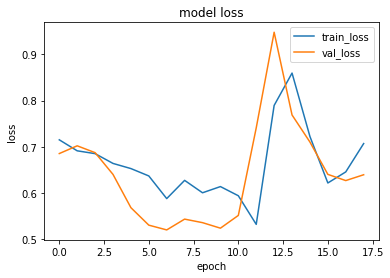

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.44915286]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.4811109]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.48843312]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.41575405]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.40380582]]


1it [00:00, 9986.44it/s]


prediction for video control_3.mov is [[0.40183398]]
Epoch 1/75
3/3 [==============================] - 1s 443ms/step - loss: 0.6963 - accuracy: 0.4875 - precision_134: 0.4821 - recall_134: 0.6923 - val_loss: 0.6970 - val_accuracy: 0.5000 - val_precision_134: 0.5455 - val_recall_134: 0.5455
Epoch 2/75
3/3 [==============================] - 2s 530ms/step - loss: 0.6778 - accuracy: 0.6500 - precision_134: 0.6897 - recall_134: 0.5128 - val_loss: 0.6791 - val_accuracy: 0.5500 - val_precision_134: 0.6667 - val_recall_134: 0.3636
Epoch 3/75
3/3 [==============================] - 1s 432ms/step - loss: 0.6715 - accuracy: 0.6250 - precision_134: 0.7368 - recall_134: 0.3590 - val_loss: 0.6514 - val_accuracy: 0.6500 - val_precision_134: 0.7000 - val_recall_134: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 476ms/step - loss: 0.6455 - accuracy: 0.6875 - precision_134: 0.6842 - recall_134: 0.6667 - val_loss: 0.5879 - val_accuracy: 0.6500 - val_precision_134: 0.7000 - val_recall_134: 0.

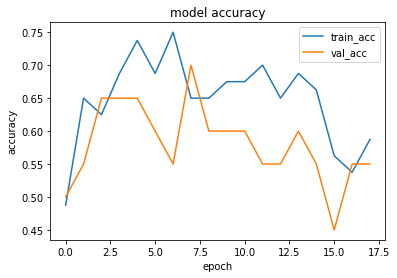

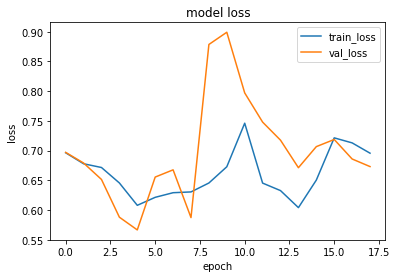

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5564283]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.5686304]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.563094]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.5534375]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.55212]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.5518731]]
Epoch 1/75
3/3 [==============================] - 1s 364ms/step - loss: 0.7183 - accuracy: 0.4500 - precision_135: 0.4600 - recall_135: 0.5750 - val_loss: 0.6993 - val_accuracy: 0.5000 - val_precision_135: 0.5000 - val_recall_135: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6926 - accuracy: 0.5000 - precision_135: 0.5000 - recall_135: 0.6500 - val_loss: 0.6899 - val_accuracy: 0.5500 - val_precision_135: 0.6000 - val_recall_135: 0.3000
Epoch 3/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6716 - accuracy: 0.6500 - precision_135: 0.6429 - recall_135: 0.6750 - val_loss: 0.6770 - val_accuracy: 0.7500 - val_precision_135: 0.7778 - val_recall_135: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 428ms/step - loss: 0.6478 - accuracy: 0.7875 - precision_135: 0.7556 - recall_135: 0.8500 - val_loss: 0.6640 - val_accuracy: 0.5500 - val_precision_135: 0.5294 - val_recall_135: 0.9

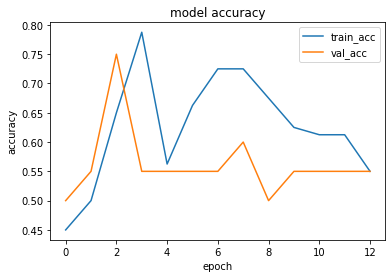

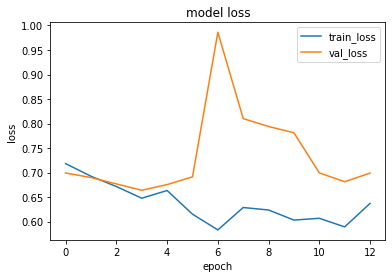

1it [00:00, 14563.56it/s]


prediction for video armflapping_1.mov is [[0.5461894]]


1it [00:00, 12520.31it/s]


prediction for video armflapping_3.mov is [[0.5771079]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.56626165]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.5311793]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.5254975]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.5252061]]
Epoch 1/75
3/3 [==============================] - 1s 367ms/step - loss: 0.7056 - accuracy: 0.4250 - precision_136: 0.3333 - recall_136: 0.0698 - val_loss: 0.6998 - val_accuracy: 0.2500 - val_precision_136: 0.2143 - val_recall_136: 0.4286
Epoch 2/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6864 - accuracy: 0.5000 - precision_136: 0.5246 - recall_136: 0.7442 - val_loss: 0.7250 - val_accuracy: 0.3500 - val_precision_136: 0.3500 - val_recall_136: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 435ms/step - loss: 0.6820 - accuracy: 0.5625 - precision_136: 0.5513 - recall_136: 1.0000 - val_loss: 0.7255 - val_accuracy: 0.3500 - val_precision_136: 0.3500 - val_recall_136: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 367ms/step - loss: 0.6689 - accuracy: 0.5750 - precision_136: 0.5584 - recall_136: 1.0000 - val_loss: 0.7069 - val_accuracy: 0.3500 - val_precision_136: 0.3333 - val_recall_136: 0.8

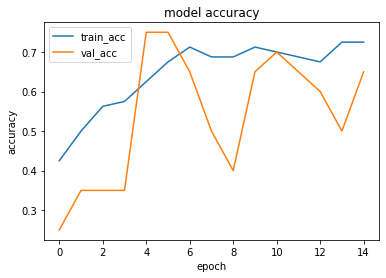

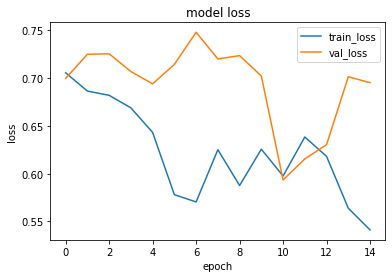

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.50556666]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5265052]]


1it [00:00, 11244.78it/s]


prediction for video armflapping_2.mov is [[0.53406984]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.4869021]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.4750517]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.47546044]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6871 - accuracy: 0.5000 - precision_137: 0.5000 - recall_137: 0.3250 - val_loss: 0.6740 - val_accuracy: 0.5000 - val_precision_137: 0.5000 - val_recall_137: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 365ms/step - loss: 0.6608 - accuracy: 0.5625 - precision_137: 0.5397 - recall_137: 0.8500 - val_loss: 0.6956 - val_accuracy: 0.5000 - val_precision_137: 0.5000 - val_recall_137: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6361 - accuracy: 0.6125 - precision_137: 0.5692 - recall_137: 0.9250 - val_loss: 0.6604 - val_accuracy: 0.5000 - val_precision_137: 0.5000 - val_recall_137: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6385 - accuracy: 0.6250 - precision_137: 0.5806 - recall_137: 0.9000 - val_loss: 0.6249 - val_accuracy: 0.6000 - val_precision_137: 0.5556 - val_recall_137: 1.

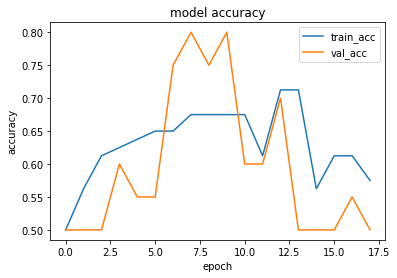

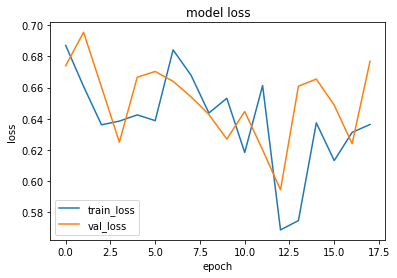

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.58947265]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.6008979]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_2.mov is [[0.6196856]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.5693115]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.5582022]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.5554807]]


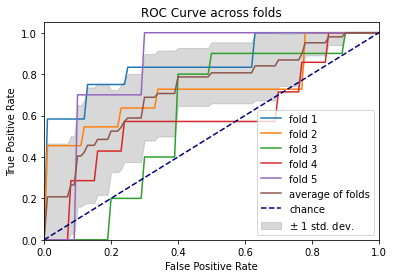

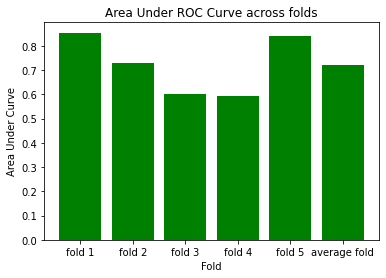

In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6905 - accuracy: 0.5375 - precision_139: 0.5263 - recall_139: 0.2632 - val_loss: 0.6850 - val_accuracy: 0.4500 - val_precision_139: 1.0000 - val_recall_139: 0.0833
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6620 - accuracy: 0.5875 - precision_139: 0.7273 - recall_139: 0.2105 - val_loss: 0.6123 - val_accuracy: 0.8500 - val_precision_139: 0.9091 - val_recall_139: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6718 - accuracy: 0.6625 - precision_139: 0.6279 - recall_139: 0.7105 - val_loss: 0.5287 - val_accuracy: 0.7500 - val_precision_139: 0.7692 - val_recall_139: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6445 - accuracy: 0.5875 - precision_139: 0.5758 - recall_139: 0.5000 - val_loss: 0.5774 - val_accuracy: 0.8000 - val_precision_139: 1.0000 - val_recall_139: 0.6667
Epoch 5/75
3/3 [==============================] 

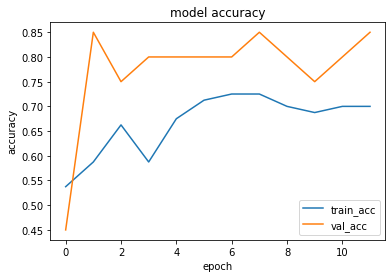

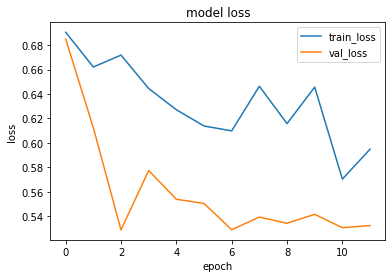

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.4818121]]


1it [00:00, 9776.93it/s]


prediction for video armflapping_3.mov is [[0.4875589]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.5041967]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.46617725]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.46064973]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.45669368]]
Epoch 1/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6737 - accuracy: 0.7000 - precision_140: 0.6471 - recall_140: 0.8462 - val_loss: 0.6975 - val_accuracy: 0.5000 - val_precision_140: 0.5333 - val_recall_140: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6655 - accuracy: 0.6375 - precision_140: 0.5893 - recall_140: 0.8462 - val_loss: 0.7079 - val_accuracy: 0.5000 - val_precision_140: 0.5385 - val_recall_140: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 329ms/step - loss: 0.6514 - accuracy: 0.6875 - precision_140: 0.6591 - recall_140: 0.7436 - val_loss: 0.6984 - val_accuracy: 0.5500 - val_precision_140: 0.6250 - val_recall_140: 0.4545
Epoch 4/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6107 - accuracy: 0.6500 - precision_140: 0.6897 - recall_140: 0.5128 - val_loss: 0.6397 - val_accuracy: 0.6000 - val_precision_140: 0.6154 - val_recall_140: 0.

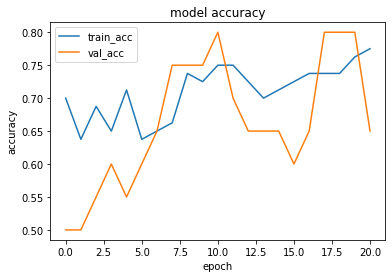

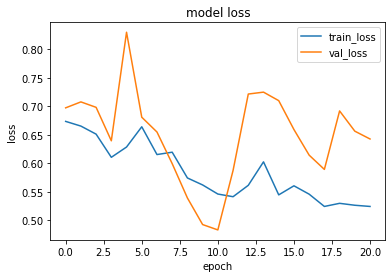

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.16271576]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.7379434]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.70562774]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.13528606]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.13088405]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.13840011]]
Epoch 1/75
3/3 [==============================] - 1s 374ms/step - loss: 0.6913 - accuracy: 0.5000 - precision_141: 0.5000 - recall_141: 0.6750 - val_loss: 0.6788 - val_accuracy: 0.6000 - val_precision_141: 0.5556 - val_recall_141: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 393ms/step - loss: 0.6827 - accuracy: 0.5875 - precision_141: 0.5686 - recall_141: 0.7250 - val_loss: 0.6637 - val_accuracy: 0.6500 - val_precision_141: 0.7143 - val_recall_141: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6514 - accuracy: 0.6875 - precision_141: 0.6829 - recall_141: 0.7000 - val_loss: 0.6544 - val_accuracy: 0.7000 - val_precision_141: 0.7500 - val_recall_141: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6163 - accuracy: 0.7375 - precision_141: 0.7436 - recall_141: 0.7250 - val_loss: 0.6810 - val_accuracy: 0.7500 - val_precision_141: 0.7273 - val_recall_141: 0.

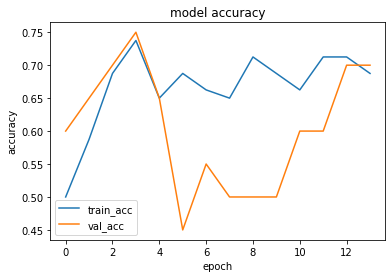

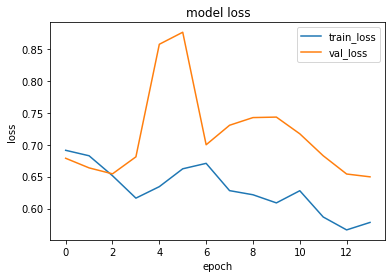

1it [00:00, 12483.05it/s]


prediction for video armflapping_1.mov is [[0.45270813]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.55033]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.5892604]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.3018164]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.24464849]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.3044132]]
Epoch 1/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6954 - accuracy: 0.4125 - precision_142: 0.4630 - recall_142: 0.5814 - val_loss: 0.7204 - val_accuracy: 0.4000 - val_precision_142: 0.3529 - val_recall_142: 0.8571
Epoch 2/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6724 - accuracy: 0.5875 - precision_142: 0.5658 - recall_142: 1.0000 - val_loss: 0.7375 - val_accuracy: 0.4000 - val_precision_142: 0.3529 - val_recall_142: 0.8571
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6481 - accuracy: 0.6000 - precision_142: 0.5733 - recall_142: 1.0000 - val_loss: 0.7371 - val_accuracy: 0.4000 - val_precision_142: 0.3333 - val_recall_142: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6300 - accuracy: 0.5875 - precision_142: 0.6000 - recall_142: 0.6977 - val_loss: 0.7543 - val_accuracy: 0.4000 - val_precision_142: 0.3333 - val_recall_142: 0.7

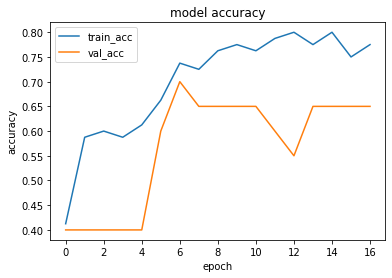

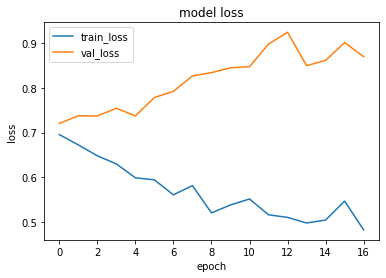

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.6124984]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.664783]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6888124]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.53148144]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.52124184]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.32843512]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.7107 - accuracy: 0.4875 - precision_143: 0.4815 - recall_143: 0.3250 - val_loss: 0.7081 - val_accuracy: 0.2500 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6833 - accuracy: 0.4875 - precision_143: 0.4872 - recall_143: 0.4750 - val_loss: 0.6924 - val_accuracy: 0.5000 - val_precision_143: 0.5000 - val_recall_143: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6830 - accuracy: 0.5125 - precision_143: 0.5072 - recall_143: 0.8750 - val_loss: 0.6848 - val_accuracy: 0.5000 - val_precision_143: 0.5000 - val_recall_143: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6888 - accuracy: 0.4625 - precision_143: 0.4769 - recall_143: 0.7750 - val_loss: 0.6768 - val_accuracy: 0.5000 - val_precision_143: 0.5000 - val_recall

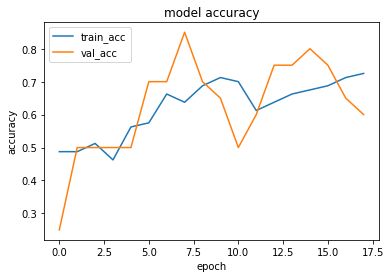

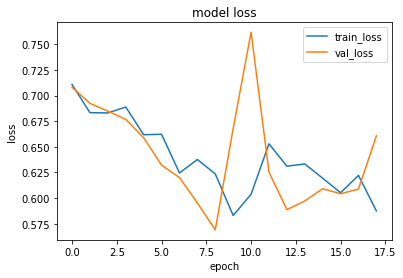

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5335491]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5901236]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.62087595]]


1it [00:00, 15252.01it/s]


prediction for video control_1.mov is [[0.20868695]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.20737442]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.207171]]


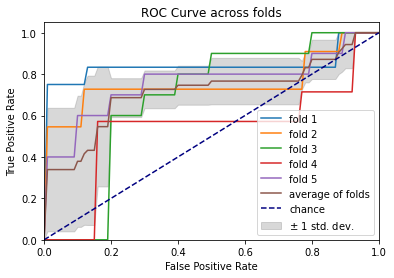

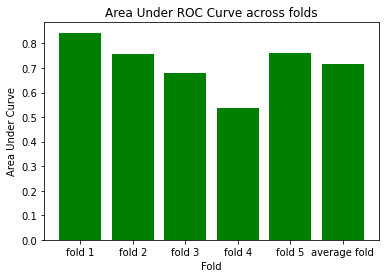

In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 453ms/step - loss: 0.7051 - accuracy: 0.4750 - precision_145: 0.3889 - recall_145: 0.1842 - val_loss: 0.6932 - val_accuracy: 0.4500 - val_precision_145: 1.0000 - val_recall_145: 0.0833
Epoch 2/75
3/3 [==============================] - 1s 378ms/step - loss: 0.6814 - accuracy: 0.6000 - precision_145: 0.7143 - recall_145: 0.2632 - val_loss: 0.6750 - val_accuracy: 0.5000 - val_precision_145: 1.0000 - val_recall_145: 0.1667
Epoch 3/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6544 - accuracy: 0.6250 - precision_145: 0.6818 - recall_145: 0.3947 - val_loss: 0.6208 - val_accuracy: 0.7500 - val_precision_145: 1.0000 - val_recall_145: 0.5833
Epoch 4/75
3/3 [==============================] - 1s 389ms/step - loss: 0.6703 - accuracy: 0.6375 - precision_145: 0.6667 - recall_145: 0.4737 - val_loss: 0.6136 - val_accuracy: 0.8500 - val_precision_145: 1.0000 - val_recall_145: 0.7500
Epoch 5/75
3/3 [==============================] 

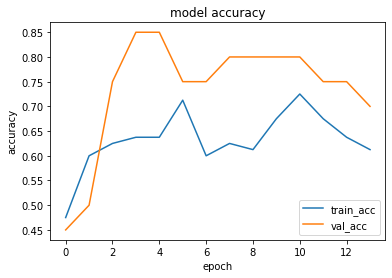

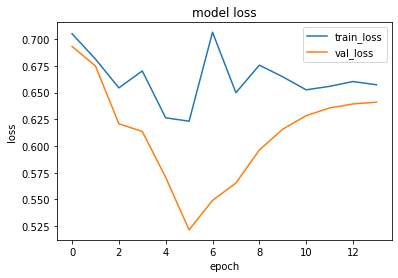

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.4796113]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.47908723]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.48181614]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.46822193]]


1it [00:00, 13189.64it/s]


prediction for video control_2.mov is [[0.46317613]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.45858178]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.7110 - accuracy: 0.3625 - precision_146: 0.4118 - recall_146: 0.7179 - val_loss: 0.6838 - val_accuracy: 0.6000 - val_precision_146: 0.5789 - val_recall_146: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6828 - accuracy: 0.6000 - precision_146: 0.5660 - recall_146: 0.7692 - val_loss: 0.6449 - val_accuracy: 0.7500 - val_precision_146: 1.0000 - val_recall_146: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 357ms/step - loss: 0.6731 - accuracy: 0.6625 - precision_146: 0.6765 - recall_146: 0.5897 - val_loss: 0.6106 - val_accuracy: 0.7000 - val_precision_146: 0.7273 - val_recall_146: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 429ms/step - loss: 0.6349 - accuracy: 0.7375 - precision_146: 0.6875 - recall_146: 0.8462 - val_loss: 0.5730 - val_accuracy: 0.7000 - val_precision_146: 0.7778 - val_recall_146: 0.

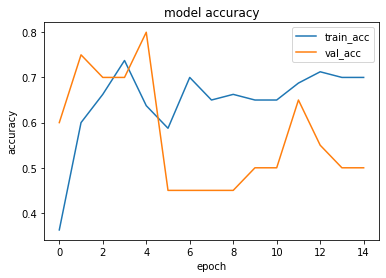

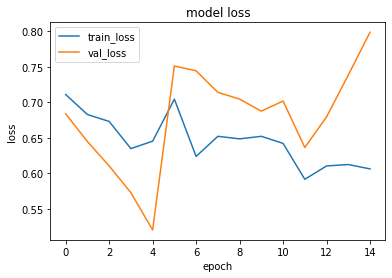

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.29252553]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.52856874]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.5769954]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.19177312]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.18183193]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.18618837]]
Epoch 1/75
3/3 [==============================] - 1s 357ms/step - loss: 0.7021 - accuracy: 0.4625 - precision_147: 0.4754 - recall_147: 0.7250 - val_loss: 0.6971 - val_accuracy: 0.6000 - val_precision_147: 0.5833 - val_recall_147: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6671 - accuracy: 0.7125 - precision_147: 0.6604 - recall_147: 0.8750 - val_loss: 0.6792 - val_accuracy: 0.7000 - val_precision_147: 0.7000 - val_recall_147: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6561 - accuracy: 0.7000 - precision_147: 0.6739 - recall_147: 0.7750 - val_loss: 0.6594 - val_accuracy: 0.6000 - val_precision_147: 0.5833 - val_recall_147: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6210 - accuracy: 0.7000 - precision_147: 0.6905 - recall_147: 0.7250 - val_loss: 0.7049 - val_accuracy: 0.6000 - val_precision_147: 0.5625 - val_recall_147: 0.

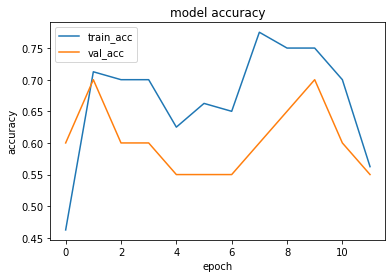

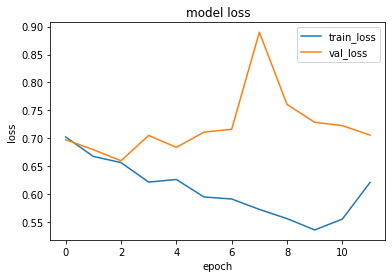

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.5769527]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.5976272]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5958167]]


1it [00:00, 3132.42it/s]


prediction for video control_1.mov is [[0.5401782]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.5113304]]


1it [00:00, 8943.08it/s]


prediction for video control_3.mov is [[0.5158076]]
Epoch 1/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6997 - accuracy: 0.4250 - precision_148: 0.4706 - recall_148: 0.5581 - val_loss: 0.7047 - val_accuracy: 0.4000 - val_precision_148: 0.3684 - val_recall_148: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6669 - accuracy: 0.6125 - precision_148: 0.5811 - recall_148: 1.0000 - val_loss: 0.7108 - val_accuracy: 0.4000 - val_precision_148: 0.3333 - val_recall_148: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6429 - accuracy: 0.6250 - precision_148: 0.6140 - recall_148: 0.8140 - val_loss: 0.8587 - val_accuracy: 0.3500 - val_precision_148: 0.3125 - val_recall_148: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6309 - accuracy: 0.6250 - precision_148: 0.5970 - recall_148: 0.9302 - val_loss: 0.7386 - val_accuracy: 0.4000 - val_precision_148: 0.3333 - val_recall_148: 0.7

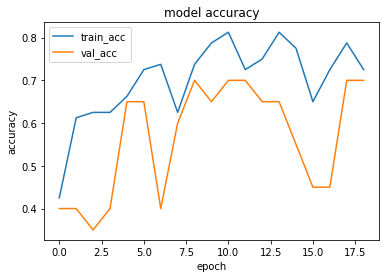

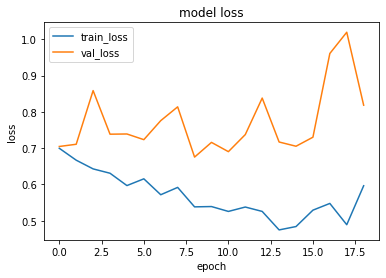

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.5257257]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.6352916]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6764896]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.31424984]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.26067433]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.24993962]]
Epoch 1/75
3/3 [==============================] - 1s 397ms/step - loss: 0.7012 - accuracy: 0.5250 - precision_149: 0.5132 - recall_149: 0.9750 - val_loss: 0.6742 - val_accuracy: 0.5000 - val_precision_149: 0.5000 - val_recall_149: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6909 - accuracy: 0.6000 - precision_149: 0.5909 - recall_149: 0.6500 - val_loss: 0.6789 - val_accuracy: 0.7500 - val_precision_149: 0.7778 - val_recall_149: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6841 - accuracy: 0.5875 - precision_149: 0.6842 - recall_149: 0.3250 - val_loss: 0.6727 - val_accuracy: 0.8000 - val_precision_149: 0.7500 - val_recall_149: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 357ms/step - loss: 0.6815 - accuracy: 0.5500 - precision_149: 0.5667 - recall_149: 0.4250 - val_loss: 0.6627 - val_accuracy: 0.8000 - val_precision_149: 0.7500 - val_recall_149: 0.

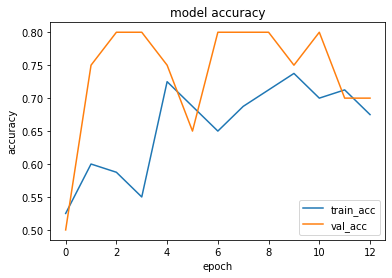

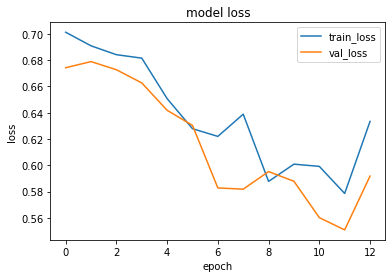

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.65028566]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_3.mov is [[0.6945161]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.70141435]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.25886694]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.24655315]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.30250564]]


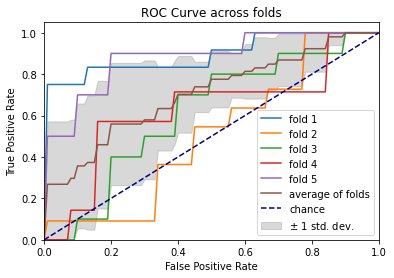

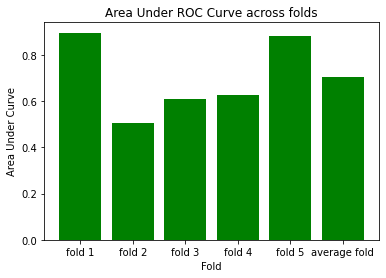

In [41]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 367ms/step - loss: 0.6998 - accuracy: 0.4750 - precision_151: 0.4000 - recall_151: 0.2105 - val_loss: 0.6606 - val_accuracy: 0.7000 - val_precision_151: 1.0000 - val_recall_151: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 377ms/step - loss: 0.6828 - accuracy: 0.5875 - precision_151: 0.6190 - recall_151: 0.3421 - val_loss: 0.6048 - val_accuracy: 0.8500 - val_precision_151: 0.9091 - val_recall_151: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6716 - accuracy: 0.6375 - precision_151: 0.6047 - recall_151: 0.6842 - val_loss: 0.5525 - val_accuracy: 0.7500 - val_precision_151: 0.7692 - val_recall_151: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6431 - accuracy: 0.6875 - precision_151: 0.6327 - recall_151: 0.8158 - val_loss: 0.5623 - val_accuracy: 0.7500 - val_precision_151: 0.7692 - val_recall_151: 0.8333
Epoch 5/75
3/3 [==============================] 

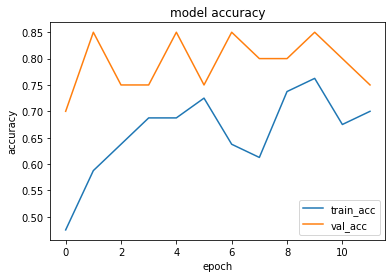

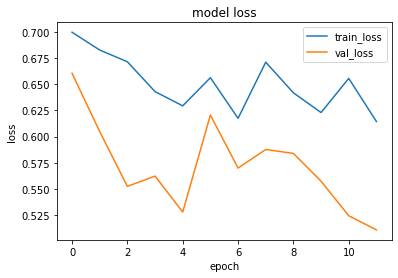

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.48888808]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.50458324]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.53525186]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.47044304]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.4641018]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.46161678]]
Epoch 1/75
3/3 [==============================] - 1s 377ms/step - loss: 0.6919 - accuracy: 0.5000 - precision_152: 0.4915 - recall_152: 0.7436 - val_loss: 0.6896 - val_accuracy: 0.5000 - val_precision_152: 0.5385 - val_recall_152: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6652 - accuracy: 0.7250 - precision_152: 0.6667 - recall_152: 0.8718 - val_loss: 0.6533 - val_accuracy: 0.6000 - val_precision_152: 0.6154 - val_recall_152: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 388ms/step - loss: 0.6554 - accuracy: 0.6750 - precision_152: 0.6275 - recall_152: 0.8205 - val_loss: 0.6285 - val_accuracy: 0.6500 - val_precision_152: 0.6667 - val_recall_152: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 357ms/step - loss: 0.6634 - accuracy: 0.6250 - precision_152: 0.6552 - recall_152: 0.4872 - val_loss: 0.6411 - val_accuracy: 0.5500 - val_precision_152: 1.0000 - val_recall_152: 0.

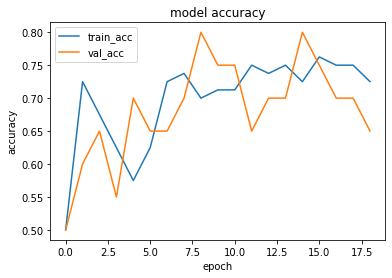

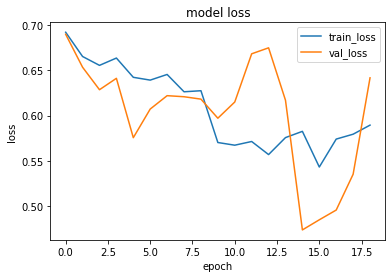

1it [00:00, 12336.19it/s]


prediction for video armflapping_1.mov is [[0.4053877]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_3.mov is [[0.4420923]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.47489458]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.3640304]]


1it [00:00, 4116.10it/s]


prediction for video control_2.mov is [[0.32698962]]


1it [00:00, 12483.05it/s]


prediction for video control_3.mov is [[0.3340147]]
Epoch 1/75
3/3 [==============================] - 1s 456ms/step - loss: 0.6973 - accuracy: 0.5375 - precision_153: 0.5224 - recall_153: 0.8750 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_precision_153: 0.5000 - val_recall_153: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 483ms/step - loss: 0.6655 - accuracy: 0.5500 - precision_153: 0.5278 - recall_153: 0.9500 - val_loss: 0.6764 - val_accuracy: 0.5000 - val_precision_153: 0.5000 - val_recall_153: 0.2000
Epoch 3/75
3/3 [==============================] - 1s 448ms/step - loss: 0.6579 - accuracy: 0.6500 - precision_153: 0.7500 - recall_153: 0.4500 - val_loss: 0.6789 - val_accuracy: 0.4000 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 1s 434ms/step - loss: 0.6148 - accuracy: 0.6750 - precision_153: 0.7059 - recall_153: 0.6000 - val_loss: 0.7876 - val_accuracy: 0.5500 - val_precision_153: 0.5385 - val_recall_

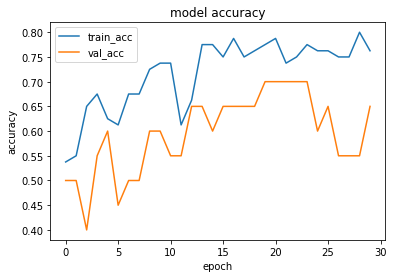

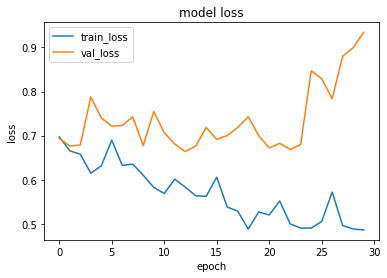

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5222025]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.69283617]]


1it [00:00, 12520.31it/s]


prediction for video armflapping_2.mov is [[0.66122574]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.24093312]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.12923571]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.22805941]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6958 - accuracy: 0.5000 - precision_154: 0.5306 - recall_154: 0.6047 - val_loss: 0.7163 - val_accuracy: 0.3500 - val_precision_154: 0.3500 - val_recall_154: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6657 - accuracy: 0.6000 - precision_154: 0.5733 - recall_154: 1.0000 - val_loss: 0.7118 - val_accuracy: 0.4000 - val_precision_154: 0.3333 - val_recall_154: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 371ms/step - loss: 0.6221 - accuracy: 0.6375 - precision_154: 0.6029 - recall_154: 0.9535 - val_loss: 0.7341 - val_accuracy: 0.7000 - val_precision_154: 0.5556 - val_recall_154: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 287ms/step - loss: 0.5956 - accuracy: 0.6375 - precision_154: 0.6591 - recall_154: 0.6744 - val_loss: 0.7086 - val_accuracy: 0.6500 - val_precision_154: 0.5000 - val_recall_154: 0.

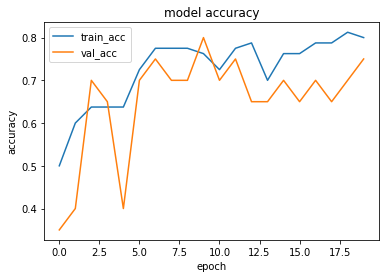

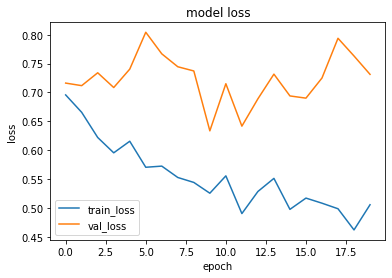

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.61254215]]


1it [00:00, 20360.70it/s]


prediction for video armflapping_3.mov is [[0.5582272]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.59434795]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.5368889]]


1it [00:00, 11748.75it/s]


prediction for video control_2.mov is [[0.47822225]]


1it [00:00, 13357.66it/s]


prediction for video control_3.mov is [[0.4906876]]
Epoch 1/75
3/3 [==============================] - 1s 320ms/step - loss: 0.7002 - accuracy: 0.3500 - precision_155: 0.0714 - recall_155: 0.0250 - val_loss: 0.6891 - val_accuracy: 0.6500 - val_precision_155: 0.7143 - val_recall_155: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6854 - accuracy: 0.5625 - precision_155: 0.5490 - recall_155: 0.7000 - val_loss: 0.6751 - val_accuracy: 0.5500 - val_precision_155: 0.5263 - val_recall_155: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 347ms/step - loss: 0.6724 - accuracy: 0.6000 - precision_155: 0.5606 - recall_155: 0.9250 - val_loss: 0.6659 - val_accuracy: 0.5000 - val_precision_155: 0.5000 - val_recall_155: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 411ms/step - loss: 0.6545 - accuracy: 0.6000 - precision_155: 0.5645 - recall_155: 0.8750 - val_loss: 0.6428 - val_accuracy: 0.7500 - val_precision_155: 0.7273 - val_recall_155: 0.8

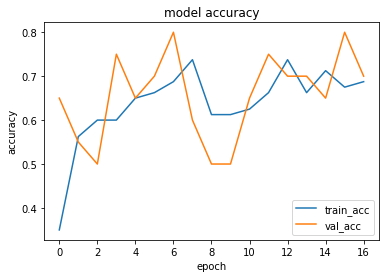

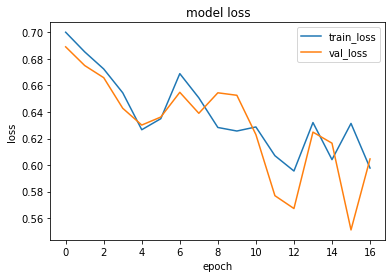

1it [00:00, 12633.45it/s]


prediction for video armflapping_1.mov is [[0.48825434]]


1it [00:00, 11618.57it/s]


prediction for video armflapping_3.mov is [[0.57751215]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.635205]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.41024864]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.3921242]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.38641918]]


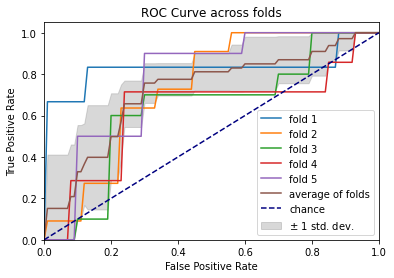

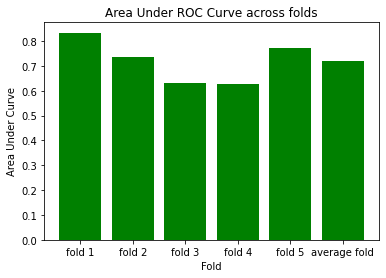

In [42]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 417ms/step - loss: 0.7022 - accuracy: 0.4500 - precision_157: 0.4062 - recall_157: 0.3421 - val_loss: 0.6892 - val_accuracy: 0.4500 - val_precision_157: 0.6667 - val_recall_157: 0.1667
Epoch 2/75
3/3 [==============================] - 1s 328ms/step - loss: 0.6795 - accuracy: 0.5000 - precision_157: 0.4444 - recall_157: 0.2105 - val_loss: 0.6650 - val_accuracy: 0.5000 - val_precision_157: 0.7500 - val_recall_157: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6550 - accuracy: 0.6250 - precision_157: 0.5952 - recall_157: 0.6579 - val_loss: 0.6130 - val_accuracy: 0.6500 - val_precision_157: 0.6316 - val_recall_157: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6447 - accuracy: 0.5750 - precision_157: 0.5303 - recall_157: 0.9211 - val_loss: 0.6115 - val_accuracy: 0.6500 - val_precision_157: 0.6316 - val_recall_157: 1.0000
Epoch 5/75
3/3 [==============================] 

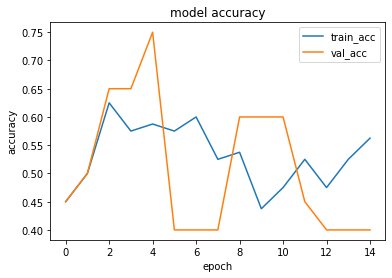

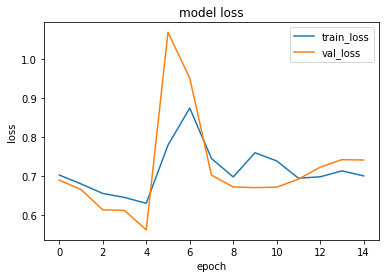

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5241562]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5283689]]


1it [00:00, 8473.34it/s]


prediction for video armflapping_2.mov is [[0.5407501]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.51596034]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.5114921]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.5118362]]
Epoch 1/75
3/3 [==============================] - 1s 347ms/step - loss: 0.6802 - accuracy: 0.6875 - precision_158: 0.6842 - recall_158: 0.6667 - val_loss: 0.6594 - val_accuracy: 0.6500 - val_precision_158: 0.7000 - val_recall_158: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 409ms/step - loss: 0.6855 - accuracy: 0.5875 - precision_158: 0.5517 - recall_158: 0.8205 - val_loss: 0.6302 - val_accuracy: 0.7000 - val_precision_158: 0.8571 - val_recall_158: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6468 - accuracy: 0.7000 - precision_158: 0.7778 - recall_158: 0.5385 - val_loss: 0.6141 - val_accuracy: 0.6500 - val_precision_158: 1.0000 - val_recall_158: 0.3636
Epoch 4/75
3/3 [==============================] - 1s 380ms/step - loss: 0.6427 - accuracy: 0.6000 - precision_158: 0.6842 - recall_158: 0.3333 - val_loss: 0.5996 - val_accuracy: 0.7000 - val_precision_158: 0.8571 - val_recall_158: 0.5

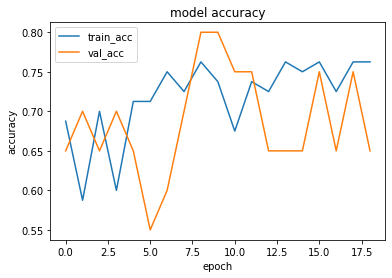

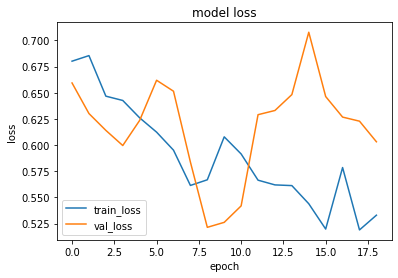

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.48151344]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.50968206]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.5196937]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.43450183]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.4056907]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.39624408]]
Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.7019 - accuracy: 0.4500 - precision_159: 0.4375 - recall_159: 0.3500 - val_loss: 0.6773 - val_accuracy: 0.6000 - val_precision_159: 0.5833 - val_recall_159: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 403ms/step - loss: 0.6798 - accuracy: 0.5250 - precision_159: 0.5179 - recall_159: 0.7250 - val_loss: 0.6776 - val_accuracy: 0.6000 - val_precision_159: 0.5556 - val_recall_159: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6645 - accuracy: 0.5375 - precision_159: 0.5200 - recall_159: 0.9750 - val_loss: 0.6653 - val_accuracy: 0.6000 - val_precision_159: 0.5556 - val_recall_159: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6327 - accuracy: 0.5750 - precision_159: 0.5429 - recall_159: 0.9500 - val_loss: 0.6802 - val_accuracy: 0.6000 - val_precision_159: 0.5714 - val_recall_159: 0.

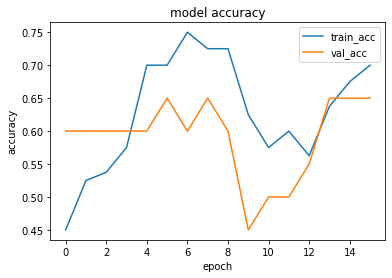

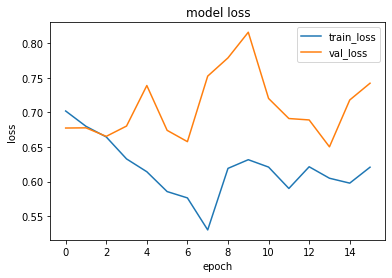

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.52686954]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.549728]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5245238]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.50607127]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.49266124]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.49515525]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6968 - accuracy: 0.4500 - precision_160: 0.4923 - recall_160: 0.7442 - val_loss: 0.7020 - val_accuracy: 0.3500 - val_precision_160: 0.3125 - val_recall_160: 0.7143
Epoch 2/75
3/3 [==============================] - 1s 278ms/step - loss: 0.6678 - accuracy: 0.5875 - precision_160: 0.5735 - recall_160: 0.9070 - val_loss: 0.6920 - val_accuracy: 0.6500 - val_precision_160: 0.5000 - val_recall_160: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 278ms/step - loss: 0.6383 - accuracy: 0.6125 - precision_160: 0.6071 - recall_160: 0.7907 - val_loss: 0.7560 - val_accuracy: 0.4000 - val_precision_160: 0.3333 - val_recall_160: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6064 - accuracy: 0.6750 - precision_160: 0.6269 - recall_160: 0.9767 - val_loss: 0.7884 - val_accuracy: 0.4000 - val_precision_160: 0.3333 - val_recall_160: 0.

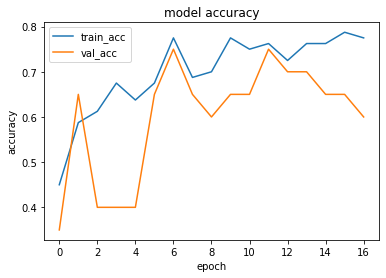

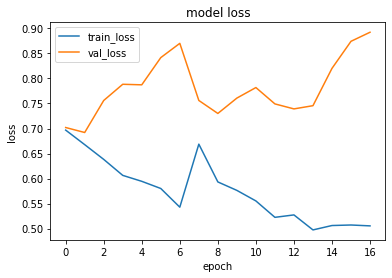

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.5943854]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.5607286]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.627491]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.55542254]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.48754317]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.52354056]]
Epoch 1/75
3/3 [==============================] - 1s 285ms/step - loss: 0.7053 - accuracy: 0.5250 - precision_161: 0.5357 - recall_161: 0.3750 - val_loss: 0.6798 - val_accuracy: 0.7500 - val_precision_161: 0.7273 - val_recall_161: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 357ms/step - loss: 0.6839 - accuracy: 0.5500 - precision_161: 0.5556 - recall_161: 0.5000 - val_loss: 0.6737 - val_accuracy: 0.8000 - val_precision_161: 0.7143 - val_recall_161: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6756 - accuracy: 0.6250 - precision_161: 0.6087 - recall_161: 0.7000 - val_loss: 0.6646 - val_accuracy: 0.8000 - val_precision_161: 0.7500 - val_recall_161: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6565 - accuracy: 0.6750 - precision_161: 0.6522 - recall_161: 0.7500 - val_loss: 0.6479 - val_accuracy: 0.7000 - val_precision_161: 0.6250 - val_recall_161: 1.

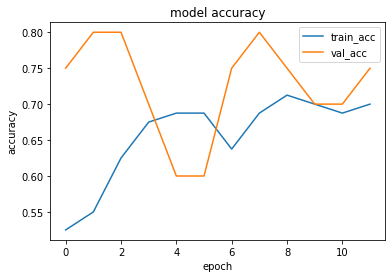

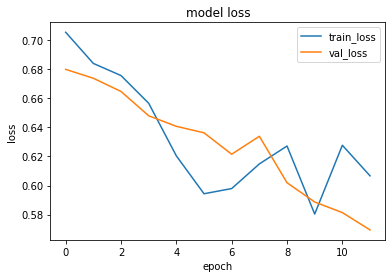

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.4591788]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.53361505]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.58131236]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3608449]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.33118385]]


1it [00:00, 12520.31it/s]


prediction for video control_3.mov is [[0.3425929]]


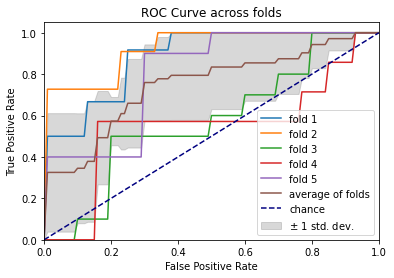

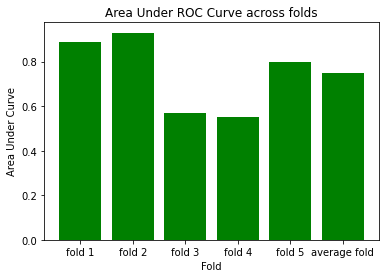

In [43]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 401ms/step - loss: 0.6942 - accuracy: 0.5375 - precision_163: 0.5185 - recall_163: 0.3684 - val_loss: 0.6593 - val_accuracy: 0.7000 - val_precision_163: 1.0000 - val_recall_163: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6770 - accuracy: 0.5500 - precision_163: 0.5278 - recall_163: 0.5000 - val_loss: 0.6131 - val_accuracy: 0.6500 - val_precision_163: 0.6316 - val_recall_163: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6538 - accuracy: 0.6125 - precision_163: 0.5574 - recall_163: 0.8947 - val_loss: 0.5668 - val_accuracy: 0.7500 - val_precision_163: 0.7692 - val_recall_163: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6440 - accuracy: 0.6875 - precision_163: 0.6383 - recall_163: 0.7895 - val_loss: 0.5420 - val_accuracy: 0.8500 - val_precision_163: 0.9091 - val_recall_163: 0.8333
Epoch 5/75
3/3 [==============================] 

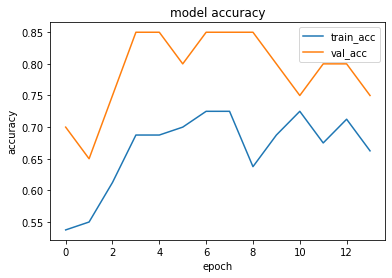

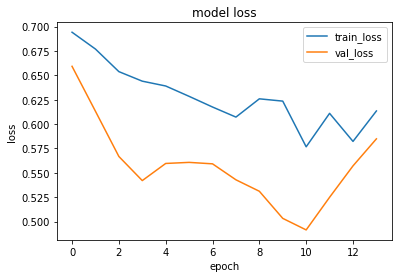

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.45000565]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.48209935]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.5288733]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.4194166]]


1it [00:00, 5405.03it/s]


prediction for video control_2.mov is [[0.40981716]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.40978378]]
Epoch 1/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6948 - accuracy: 0.4625 - precision_164: 0.4722 - recall_164: 0.8718 - val_loss: 0.6898 - val_accuracy: 0.5500 - val_precision_164: 0.5714 - val_recall_164: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 344ms/step - loss: 0.6791 - accuracy: 0.6000 - precision_164: 0.5854 - recall_164: 0.6154 - val_loss: 0.6601 - val_accuracy: 0.6000 - val_precision_164: 0.6667 - val_recall_164: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6548 - accuracy: 0.6875 - precision_164: 0.6750 - recall_164: 0.6923 - val_loss: 0.6471 - val_accuracy: 0.6000 - val_precision_164: 0.6154 - val_recall_164: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6414 - accuracy: 0.6750 - precision_164: 0.6275 - recall_164: 0.8205 - val_loss: 0.6351 - val_accuracy: 0.6500 - val_precision_164: 0.7000 - val_recall_164: 0.

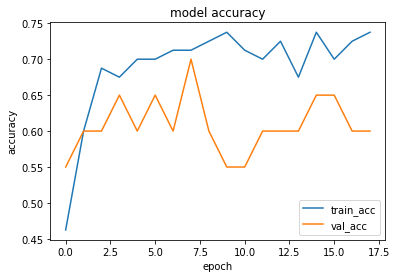

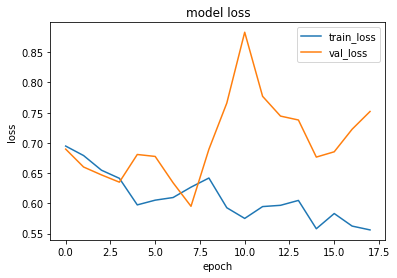

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.5307847]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.64665127]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.67250836]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.11682433]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.10397682]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.10824007]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6960 - accuracy: 0.4750 - precision_165: 0.4722 - recall_165: 0.4250 - val_loss: 0.6949 - val_accuracy: 0.6500 - val_precision_165: 0.6154 - val_recall_165: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 343ms/step - loss: 0.6788 - accuracy: 0.6000 - precision_165: 0.5625 - recall_165: 0.9000 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_precision_165: 0.5000 - val_recall_165: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6620 - accuracy: 0.6000 - precision_165: 0.5741 - recall_165: 0.7750 - val_loss: 0.6677 - val_accuracy: 0.6000 - val_precision_165: 0.6667 - val_recall_165: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 344ms/step - loss: 0.6226 - accuracy: 0.7500 - precision_165: 0.7632 - recall_165: 0.7250 - val_loss: 0.7515 - val_accuracy: 0.5000 - val_precision_165: 0.5000 - val_recall_165: 0.

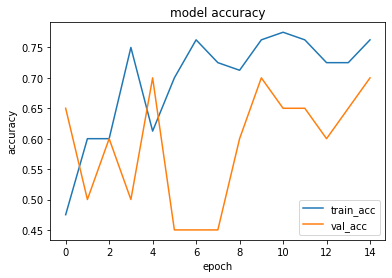

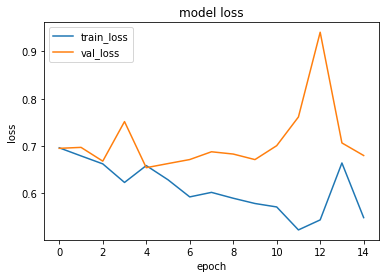

1it [00:00, 12052.60it/s]


prediction for video armflapping_1.mov is [[0.52752614]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5803993]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.5584205]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.4915495]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.47352564]]


1it [00:00, 12985.46it/s]


prediction for video control_3.mov is [[0.47256032]]
Epoch 1/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6825 - accuracy: 0.6500 - precision_166: 0.6415 - recall_166: 0.7907 - val_loss: 0.7000 - val_accuracy: 0.3500 - val_precision_166: 0.3333 - val_recall_166: 0.8571
Epoch 2/75
3/3 [==============================] - 1s 392ms/step - loss: 0.6403 - accuracy: 0.6250 - precision_166: 0.5890 - recall_166: 1.0000 - val_loss: 0.7792 - val_accuracy: 0.4500 - val_precision_166: 0.3750 - val_recall_166: 0.8571
Epoch 3/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6095 - accuracy: 0.6500 - precision_166: 0.6190 - recall_166: 0.9070 - val_loss: 0.7554 - val_accuracy: 0.6500 - val_precision_166: 0.5000 - val_recall_166: 0.5714
Epoch 4/75
3/3 [==============================] - 1s 365ms/step - loss: 0.5855 - accuracy: 0.7500 - precision_166: 0.7805 - recall_166: 0.7442 - val_loss: 0.8338 - val_accuracy: 0.6000 - val_precision_166: 0.4444 - val_recall_166: 0.

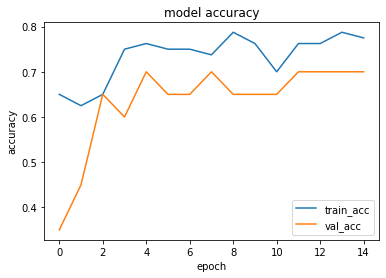

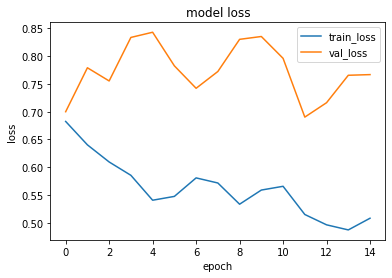

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.5404483]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5883488]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.517922]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.51665294]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.45816234]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.32129762]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.7017 - accuracy: 0.3750 - precision_167: 0.3333 - recall_167: 0.2500 - val_loss: 0.6883 - val_accuracy: 0.7000 - val_precision_167: 0.7000 - val_recall_167: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6879 - accuracy: 0.4750 - precision_167: 0.4773 - recall_167: 0.5250 - val_loss: 0.6747 - val_accuracy: 0.5000 - val_precision_167: 0.5000 - val_recall_167: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6701 - accuracy: 0.5500 - precision_167: 0.5294 - recall_167: 0.9000 - val_loss: 0.6483 - val_accuracy: 0.5500 - val_precision_167: 0.5263 - val_recall_167: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6494 - accuracy: 0.6125 - precision_167: 0.5818 - recall_167: 0.8000 - val_loss: 0.6359 - val_accuracy: 0.5500 - val_precision_167: 0.5263 - val_recall_167: 1.

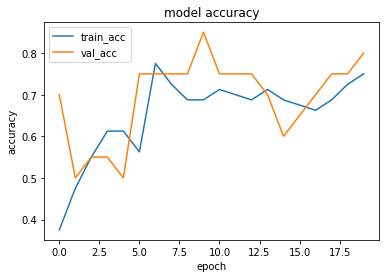

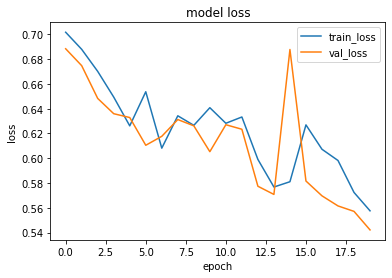

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.49705762]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5798479]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5772886]]


1it [00:00, 13357.66it/s]


prediction for video control_1.mov is [[0.42610934]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.40465653]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.39690065]]


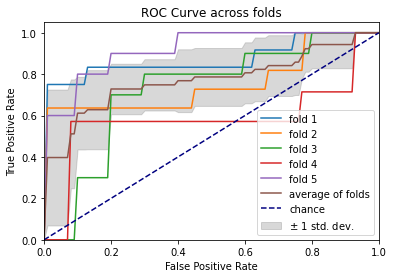

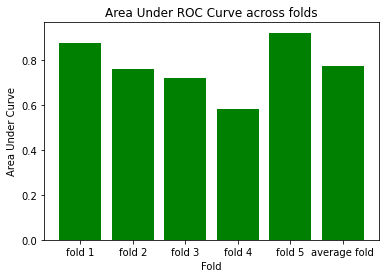

In [44]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6935 - accuracy: 0.5750 - precision_169: 0.5909 - recall_169: 0.3421 - val_loss: 0.6744 - val_accuracy: 0.7000 - val_precision_169: 1.0000 - val_recall_169: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6712 - accuracy: 0.6375 - precision_169: 0.6957 - recall_169: 0.4211 - val_loss: 0.6367 - val_accuracy: 0.8000 - val_precision_169: 0.8333 - val_recall_169: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6748 - accuracy: 0.6250 - precision_169: 0.6053 - recall_169: 0.6053 - val_loss: 0.6049 - val_accuracy: 0.8000 - val_precision_169: 0.8333 - val_recall_169: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6551 - accuracy: 0.7000 - precision_169: 0.6750 - recall_169: 0.7105 - val_loss: 0.5645 - val_accuracy: 0.8000 - val_precision_169: 0.8333 - val_recall_169: 0.8333
Epoch 5/75
3/3 [==============================] 

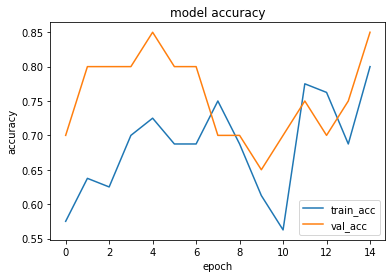

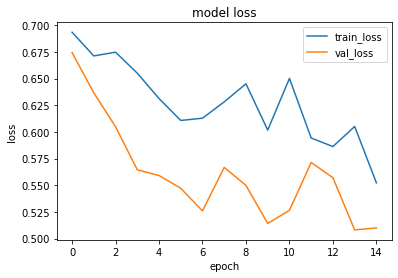

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.47050768]]


1it [00:00, 9892.23it/s]


prediction for video armflapping_3.mov is [[0.5027768]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.5207109]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.44472757]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.43476892]]


1it [00:00, 9489.38it/s]


prediction for video control_3.mov is [[0.42831326]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6935 - accuracy: 0.6375 - precision_170: 0.6389 - recall_170: 0.5897 - val_loss: 0.6908 - val_accuracy: 0.5500 - val_precision_170: 0.6000 - val_recall_170: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6736 - accuracy: 0.7125 - precision_170: 0.6905 - recall_170: 0.7436 - val_loss: 0.7047 - val_accuracy: 0.5000 - val_precision_170: 0.5385 - val_recall_170: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6812 - accuracy: 0.6500 - precision_170: 0.6341 - recall_170: 0.6667 - val_loss: 0.6671 - val_accuracy: 0.6000 - val_precision_170: 0.6667 - val_recall_170: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6509 - accuracy: 0.6375 - precision_170: 0.7083 - recall_170: 0.4359 - val_loss: 0.6603 - val_accuracy: 0.6000 - val_precision_170: 0.6667 - val_recall_170: 0.

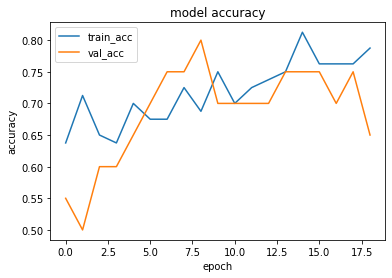

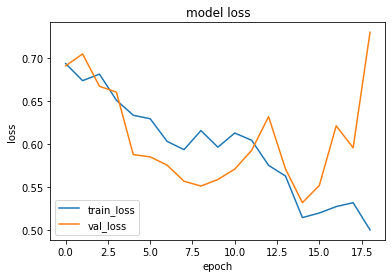

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.35893524]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.59610033]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.6316179]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.17465165]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.14993972]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.14083755]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6863 - accuracy: 0.5375 - precision_171: 0.5319 - recall_171: 0.6250 - val_loss: 0.7017 - val_accuracy: 0.5500 - val_precision_171: 0.5455 - val_recall_171: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6679 - accuracy: 0.6750 - precision_171: 0.6458 - recall_171: 0.7750 - val_loss: 0.6994 - val_accuracy: 0.5500 - val_precision_171: 0.5556 - val_recall_171: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 277ms/step - loss: 0.6386 - accuracy: 0.7250 - precision_171: 0.7647 - recall_171: 0.6500 - val_loss: 0.7128 - val_accuracy: 0.6000 - val_precision_171: 0.7500 - val_recall_171: 0.3000
Epoch 4/75
3/3 [==============================] - 1s 275ms/step - loss: 0.5991 - accuracy: 0.7000 - precision_171: 0.7857 - recall_171: 0.5500 - val_loss: 0.6886 - val_accuracy: 0.6500 - val_precision_171: 0.6364 - val_recall_171: 0.

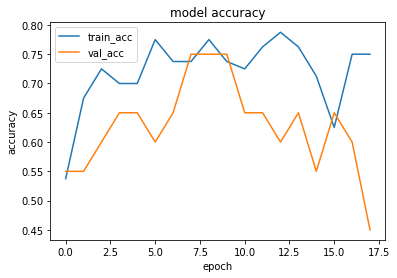

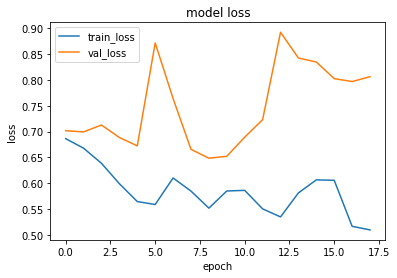

1it [00:00, 9532.51it/s]


prediction for video armflapping_1.mov is [[0.4419314]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.52363735]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.50685763]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.326264]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.20162562]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.33921784]]
Epoch 1/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6847 - accuracy: 0.5250 - precision_172: 0.5397 - recall_172: 0.7907 - val_loss: 0.7113 - val_accuracy: 0.3500 - val_precision_172: 0.3333 - val_recall_172: 0.8571
Epoch 2/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6403 - accuracy: 0.5875 - precision_172: 0.5694 - recall_172: 0.9535 - val_loss: 0.7388 - val_accuracy: 0.4000 - val_precision_172: 0.3333 - val_recall_172: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6204 - accuracy: 0.6625 - precision_172: 0.6176 - recall_172: 0.9767 - val_loss: 0.7321 - val_accuracy: 0.7000 - val_precision_172: 0.5556 - val_recall_172: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 282ms/step - loss: 0.5980 - accuracy: 0.7125 - precision_172: 0.7632 - recall_172: 0.6744 - val_loss: 0.7213 - val_accuracy: 0.7000 - val_precision_172: 0.5714 - val_recall_172: 0.

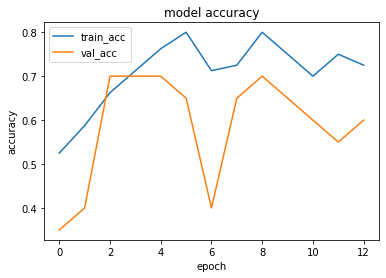

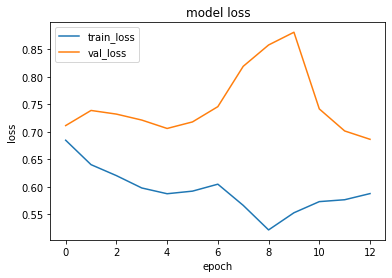

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.48647356]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.46437556]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5179943]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.42920625]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.38574722]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.39133903]]
Epoch 1/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6918 - accuracy: 0.5250 - precision_173: 0.5455 - recall_173: 0.3000 - val_loss: 0.6835 - val_accuracy: 0.7000 - val_precision_173: 1.0000 - val_recall_173: 0.4000
Epoch 2/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6649 - accuracy: 0.6125 - precision_173: 0.6452 - recall_173: 0.5000 - val_loss: 0.6762 - val_accuracy: 0.5000 - val_precision_173: 0.5000 - val_recall_173: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6327 - accuracy: 0.5875 - precision_173: 0.5522 - recall_173: 0.9250 - val_loss: 0.6708 - val_accuracy: 0.6000 - val_precision_173: 0.5714 - val_recall_173: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 276ms/step - loss: 0.6380 - accuracy: 0.6500 - precision_173: 0.6500 - recall_173: 0.6500 - val_loss: 0.6490 - val_accuracy: 0.7000 - val_precision_173: 0.8333 - val_recall_173: 0.

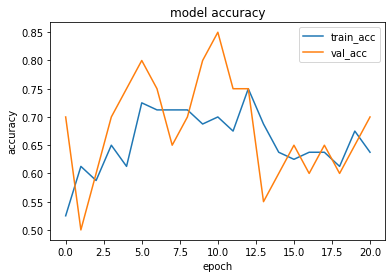

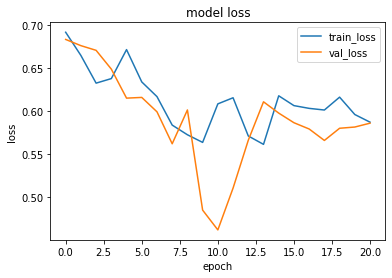

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.5964445]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.6530816]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.6509905]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.5525535]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.54951406]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.5013418]]


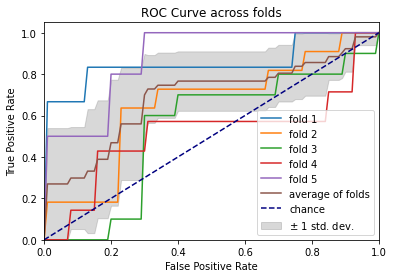

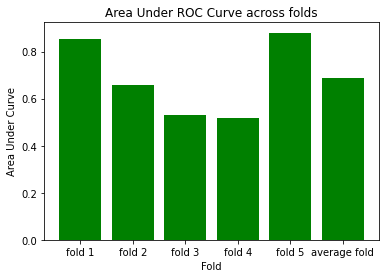

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 291ms/step - loss: 0.7079 - accuracy: 0.4250 - precision_175: 0.4200 - recall_175: 0.5526 - val_loss: 0.6761 - val_accuracy: 0.6500 - val_precision_175: 0.6316 - val_recall_175: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6879 - accuracy: 0.5125 - precision_175: 0.4898 - recall_175: 0.6316 - val_loss: 0.6873 - val_accuracy: 0.4500 - val_precision_175: 1.0000 - val_recall_175: 0.0833
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6859 - accuracy: 0.5250 - precision_175: 0.0000e+00 - recall_175: 0.0000e+00 - val_loss: 0.6923 - val_accuracy: 0.4500 - val_precision_175: 1.0000 - val_recall_175: 0.0833
Epoch 4/75
3/3 [==============================] - 1s 276ms/step - loss: 0.6751 - accuracy: 0.5375 - precision_175: 0.6667 - recall_175: 0.0526 - val_loss: 0.6386 - val_accuracy: 0.7000 - val_precision_175: 1.0000 - val_recall_175: 0.5000
Epoch 5/75
3/3 [========================

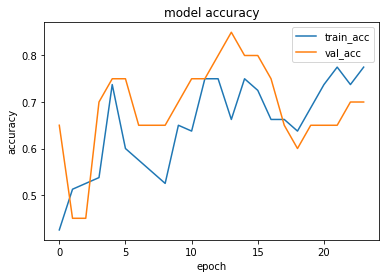

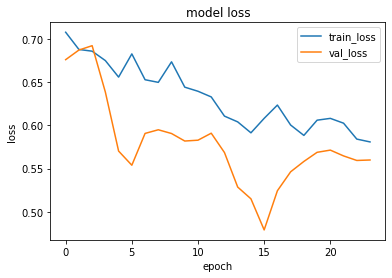

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.46045056]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.49365905]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.54854864]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.42399412]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.37571326]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.40684348]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6945 - accuracy: 0.6000 - precision_176: 0.6667 - recall_176: 0.3590 - val_loss: 0.6851 - val_accuracy: 0.6000 - val_precision_176: 0.6667 - val_recall_176: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6723 - accuracy: 0.6750 - precision_176: 0.7241 - recall_176: 0.5385 - val_loss: 0.6995 - val_accuracy: 0.5000 - val_precision_176: 0.5333 - val_recall_176: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6864 - accuracy: 0.6625 - precision_176: 0.6364 - recall_176: 0.7179 - val_loss: 0.6167 - val_accuracy: 0.6500 - val_precision_176: 0.6667 - val_recall_176: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6417 - accuracy: 0.6750 - precision_176: 0.6970 - recall_176: 0.5897 - val_loss: 0.6371 - val_accuracy: 0.6000 - val_precision_176: 0.6364 - val_recall_176: 0.

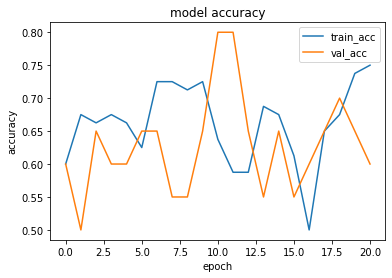

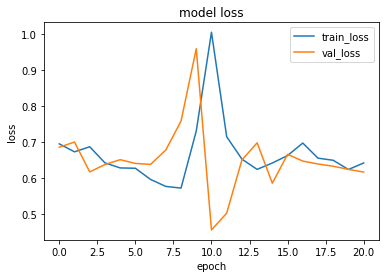

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.5549254]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.60382617]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.60041577]]


1it [00:00, 21399.51it/s]


prediction for video control_1.mov is [[0.5158832]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.5025097]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.495627]]
Epoch 1/75
3/3 [==============================] - 1s 293ms/step - loss: 0.7064 - accuracy: 0.5375 - precision_177: 0.6154 - recall_177: 0.2000 - val_loss: 0.6834 - val_accuracy: 0.6000 - val_precision_177: 0.5714 - val_recall_177: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 282ms/step - loss: 0.6781 - accuracy: 0.5125 - precision_177: 0.5085 - recall_177: 0.7500 - val_loss: 0.6850 - val_accuracy: 0.6000 - val_precision_177: 0.5556 - val_recall_177: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6617 - accuracy: 0.5750 - precision_177: 0.5441 - recall_177: 0.9250 - val_loss: 0.6812 - val_accuracy: 0.6500 - val_precision_177: 0.6667 - val_recall_177: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6236 - accuracy: 0.7625 - precision_177: 0.8000 - recall_177: 0.7000 - val_loss: 0.8089 - val_accuracy: 0.5500 - val_precision_177: 0.5455 - val_recall_177: 0.60

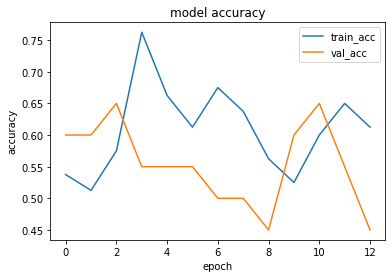

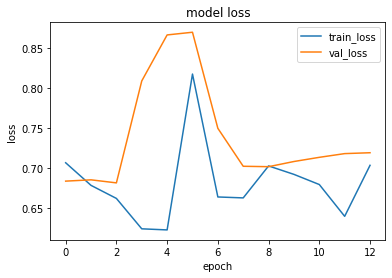

1it [00:00, 11881.88it/s]


prediction for video armflapping_1.mov is [[0.4664125]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.49302018]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.48075944]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.45635453]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.45248765]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.45210648]]
Epoch 1/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6872 - accuracy: 0.5750 - precision_178: 0.5692 - recall_178: 0.8605 - val_loss: 0.7087 - val_accuracy: 0.3500 - val_precision_178: 0.3500 - val_recall_178: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6742 - accuracy: 0.5500 - precision_178: 0.5443 - recall_178: 1.0000 - val_loss: 0.7034 - val_accuracy: 0.3500 - val_precision_178: 0.3333 - val_recall_178: 0.8571
Epoch 3/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6584 - accuracy: 0.6000 - precision_178: 0.5733 - recall_178: 1.0000 - val_loss: 0.6972 - val_accuracy: 0.4000 - val_precision_178: 0.3333 - val_recall_178: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6008 - accuracy: 0.6250 - precision_178: 0.5970 - recall_178: 0.9302 - val_loss: 0.6990 - val_accuracy: 0.7000 - val_precision_178: 0.5556 - val_recall_178: 0.

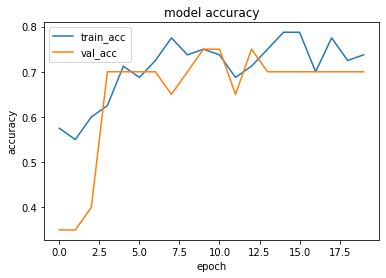

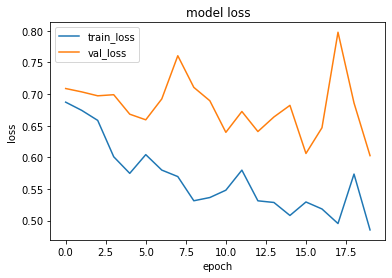

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.56109315]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.5238451]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.6289799]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.42890504]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.38625333]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.3008234]]
Epoch 1/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6907 - accuracy: 0.5250 - precision_179: 0.5179 - recall_179: 0.7250 - val_loss: 0.6742 - val_accuracy: 0.5000 - val_precision_179: 0.5000 - val_recall_179: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6571 - accuracy: 0.6000 - precision_179: 0.5556 - recall_179: 1.0000 - val_loss: 0.6796 - val_accuracy: 0.4500 - val_precision_179: 0.4737 - val_recall_179: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 274ms/step - loss: 0.6673 - accuracy: 0.6125 - precision_179: 0.5882 - recall_179: 0.7500 - val_loss: 0.6593 - val_accuracy: 0.8000 - val_precision_179: 0.7500 - val_recall_179: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 278ms/step - loss: 0.6521 - accuracy: 0.6375 - precision_179: 0.6222 - recall_179: 0.7000 - val_loss: 0.6509 - val_accuracy: 0.7000 - val_precision_179: 0.6250 - val_recall_179: 1.0

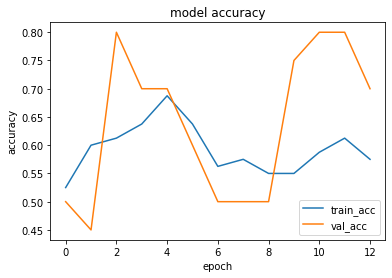

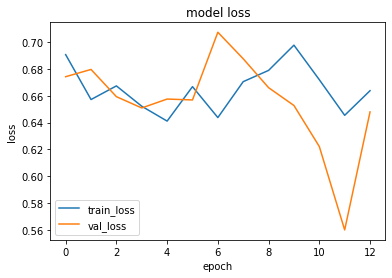

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.50076556]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.4594507]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.51979625]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.47116706]]


1it [00:00, 12228.29it/s]


prediction for video control_2.mov is [[0.45157352]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.45503718]]


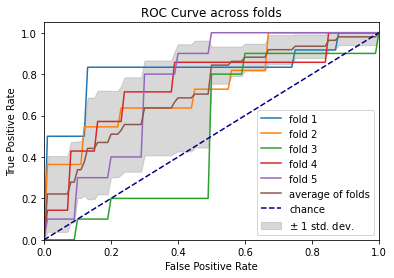

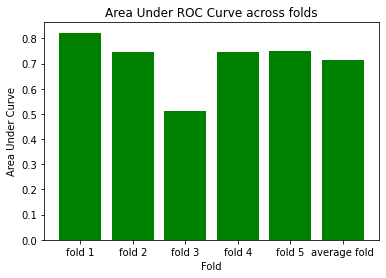

In [46]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 288ms/step - loss: 0.7035 - accuracy: 0.5000 - precision_181: 0.4615 - recall_181: 0.3158 - val_loss: 0.7085 - val_accuracy: 0.4000 - val_precision_181: 0.0000e+00 - val_recall_181: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6860 - accuracy: 0.6000 - precision_181: 0.8750 - recall_181: 0.1842 - val_loss: 0.6981 - val_accuracy: 0.4000 - val_precision_181: 0.0000e+00 - val_recall_181: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 282ms/step - loss: 0.6907 - accuracy: 0.5500 - precision_181: 0.6667 - recall_181: 0.1053 - val_loss: 0.6863 - val_accuracy: 0.4500 - val_precision_181: 1.0000 - val_recall_181: 0.0833
Epoch 4/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6764 - accuracy: 0.5750 - precision_181: 0.6667 - recall_181: 0.2105 - val_loss: 0.6508 - val_accuracy: 0.8000 - val_precision_181: 1.0000 - val_recall_181: 0.6667
Epoch 5/75
3/3 [================

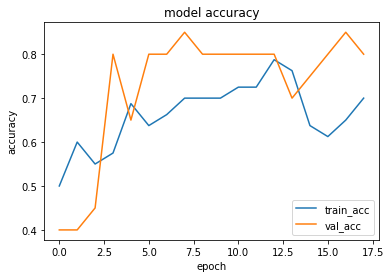

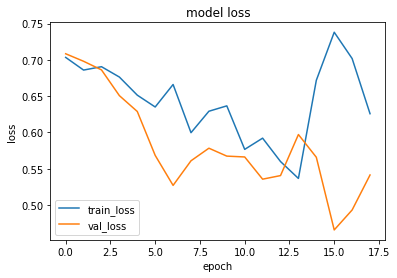

1it [00:00, 12671.61it/s]


prediction for video armflapping_1.mov is [[0.4561279]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5137122]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.52424246]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.40621108]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.38990286]]


1it [00:00, 5706.54it/s]


prediction for video control_3.mov is [[0.38876352]]
Epoch 1/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6897 - accuracy: 0.6125 - precision_182: 0.8333 - recall_182: 0.2564 - val_loss: 0.6830 - val_accuracy: 0.6000 - val_precision_182: 0.5882 - val_recall_182: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6967 - accuracy: 0.5000 - precision_182: 0.4933 - recall_182: 0.9487 - val_loss: 0.6769 - val_accuracy: 0.6000 - val_precision_182: 0.6154 - val_recall_182: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6794 - accuracy: 0.6375 - precision_182: 0.6042 - recall_182: 0.7436 - val_loss: 0.6860 - val_accuracy: 0.5000 - val_precision_182: 0.5714 - val_recall_182: 0.3636
Epoch 4/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6617 - accuracy: 0.5875 - precision_182: 0.6000 - recall_182: 0.4615 - val_loss: 0.7020 - val_accuracy: 0.5000 - val_precision_182: 0.5556 - val_recall_182: 0.

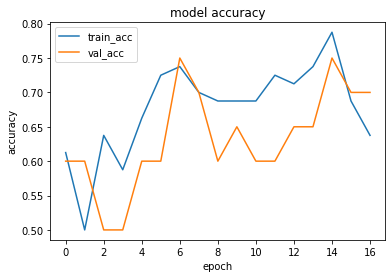

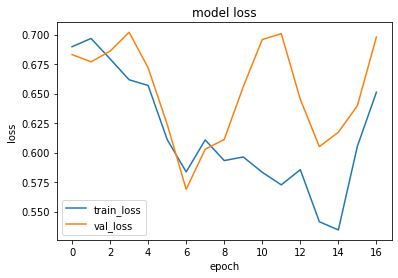

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.76184946]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.42811018]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.8016335]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.13571846]]


1it [00:00, 12052.60it/s]


prediction for video control_2.mov is [[0.6461463]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.10921016]]
Epoch 1/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6915 - accuracy: 0.5500 - precision_183: 0.6667 - recall_183: 0.2000 - val_loss: 0.6773 - val_accuracy: 0.7000 - val_precision_183: 0.7000 - val_recall_183: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6555 - accuracy: 0.6250 - precision_183: 0.5781 - recall_183: 0.9250 - val_loss: 0.6899 - val_accuracy: 0.7000 - val_precision_183: 0.6667 - val_recall_183: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 282ms/step - loss: 0.6425 - accuracy: 0.6875 - precision_183: 0.7143 - recall_183: 0.6250 - val_loss: 0.6545 - val_accuracy: 0.7500 - val_precision_183: 0.7273 - val_recall_183: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6196 - accuracy: 0.7500 - precision_183: 0.7381 - recall_183: 0.7750 - val_loss: 0.6481 - val_accuracy: 0.7000 - val_precision_183: 0.7000 - val_recall_183: 0.

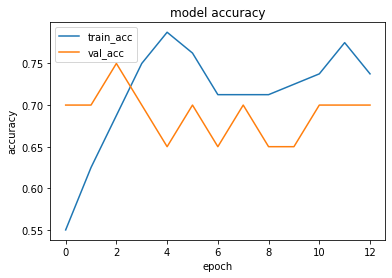

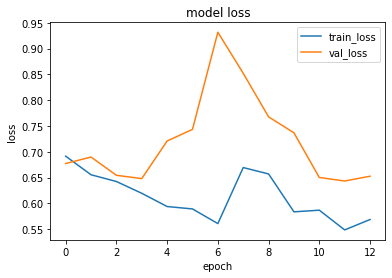

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.38658577]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.64980435]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.68234986]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.3520859]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.3447169]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.34868646]]
Epoch 1/75
3/3 [==============================] - 1s 291ms/step - loss: 0.7016 - accuracy: 0.4875 - precision_184: 0.5294 - recall_184: 0.4186 - val_loss: 0.7023 - val_accuracy: 0.4000 - val_precision_184: 0.3684 - val_recall_184: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6681 - accuracy: 0.5875 - precision_184: 0.5658 - recall_184: 1.0000 - val_loss: 0.7144 - val_accuracy: 0.4000 - val_precision_184: 0.3333 - val_recall_184: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6313 - accuracy: 0.6125 - precision_184: 0.5811 - recall_184: 1.0000 - val_loss: 0.7493 - val_accuracy: 0.4000 - val_precision_184: 0.3333 - val_recall_184: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 278ms/step - loss: 0.5839 - accuracy: 0.6875 - precision_184: 0.6364 - recall_184: 0.9767 - val_loss: 0.7158 - val_accuracy: 0.7000 - val_precision_184: 0.6000 - val_recall_184: 0.

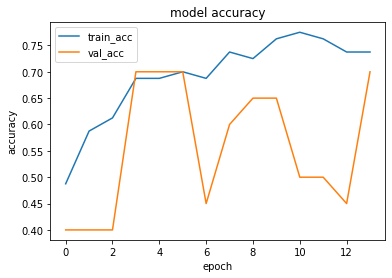

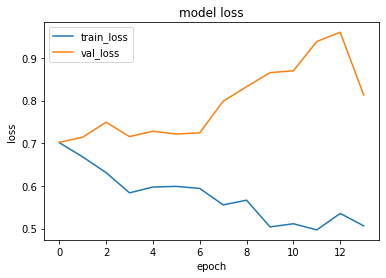

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.5959329]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.5369481]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.627686]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.52156645]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.46664006]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.4585325]]
Epoch 1/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6912 - accuracy: 0.5125 - precision_185: 0.5075 - recall_185: 0.8500 - val_loss: 0.6715 - val_accuracy: 0.5000 - val_precision_185: 0.5000 - val_recall_185: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 277ms/step - loss: 0.6703 - accuracy: 0.5625 - precision_185: 0.5362 - recall_185: 0.9250 - val_loss: 0.6562 - val_accuracy: 0.8000 - val_precision_185: 0.8750 - val_recall_185: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 275ms/step - loss: 0.6496 - accuracy: 0.6750 - precision_185: 0.7333 - recall_185: 0.5500 - val_loss: 0.6294 - val_accuracy: 0.8000 - val_precision_185: 0.7500 - val_recall_185: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6693 - accuracy: 0.6250 - precision_185: 0.6136 - recall_185: 0.6750 - val_loss: 0.6966 - val_accuracy: 0.5000 - val_precision_185: 0.5000 - val_recall_185: 1.0

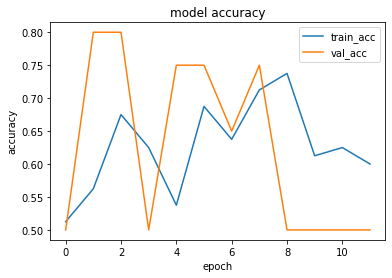

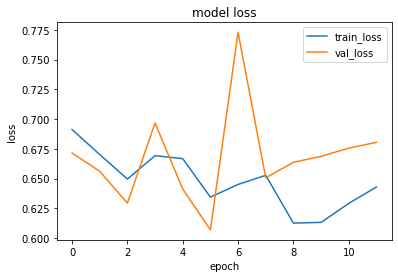

1it [00:00, 11522.81it/s]


prediction for video armflapping_1.mov is [[0.59008896]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.60687727]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.61528623]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.57146955]]


1it [00:00, 13315.25it/s]


prediction for video control_2.mov is [[0.5642505]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.5598928]]


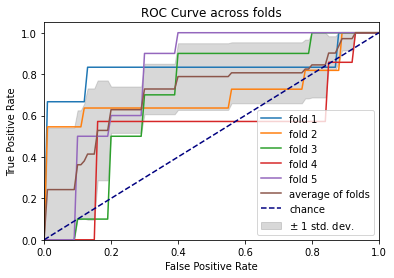

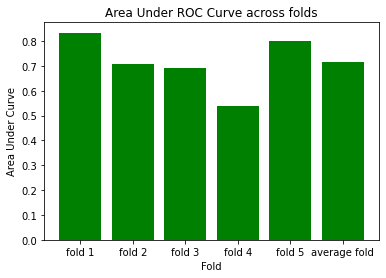

In [47]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6953 - accuracy: 0.5750 - precision_187: 0.5286 - recall_187: 0.9737 - val_loss: 0.6765 - val_accuracy: 0.8000 - val_precision_187: 1.0000 - val_recall_187: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6879 - accuracy: 0.5750 - precision_187: 0.5769 - recall_187: 0.3947 - val_loss: 0.6843 - val_accuracy: 0.5000 - val_precision_187: 1.0000 - val_recall_187: 0.1667
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6820 - accuracy: 0.5750 - precision_187: 0.5714 - recall_187: 0.4211 - val_loss: 0.6517 - val_accuracy: 0.8500 - val_precision_187: 1.0000 - val_recall_187: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 371ms/step - loss: 0.6762 - accuracy: 0.5500 - precision_187: 0.5417 - recall_187: 0.3421 - val_loss: 0.6188 - val_accuracy: 0.8500 - val_precision_187: 1.0000 - val_recall_187: 0.7500
Epoch 5/75
3/3 [==============================] 

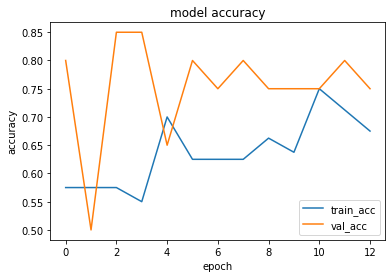

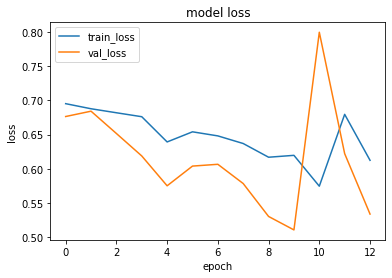

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.49037182]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.499584]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.5025213]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.48289806]]


1it [00:00, 12483.05it/s]


prediction for video control_2.mov is [[0.48146978]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.48030782]]
Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6928 - accuracy: 0.5625 - precision_188: 0.5476 - recall_188: 0.5897 - val_loss: 0.6852 - val_accuracy: 0.5000 - val_precision_188: 1.0000 - val_recall_188: 0.0909
Epoch 2/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6683 - accuracy: 0.5875 - precision_188: 0.6667 - recall_188: 0.3077 - val_loss: 0.6538 - val_accuracy: 0.6500 - val_precision_188: 1.0000 - val_recall_188: 0.3636
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6400 - accuracy: 0.6875 - precision_188: 0.6400 - recall_188: 0.8205 - val_loss: 0.6212 - val_accuracy: 0.6000 - val_precision_188: 0.8000 - val_recall_188: 0.3636
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.5936 - accuracy: 0.6750 - precision_188: 0.7241 - recall_188: 0.5385 - val_loss: 0.6147 - val_accuracy: 0.6500 - val_precision_188: 1.0000 - val_recall_188: 0.

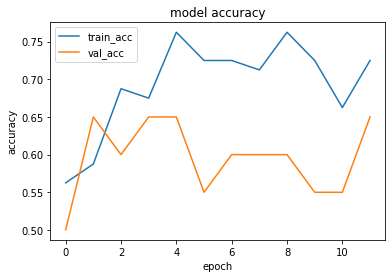

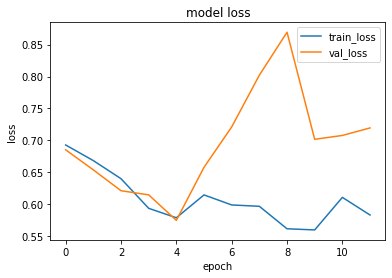

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.4309384]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.57249665]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.62275004]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.19022703]]


1it [00:00, 12633.45it/s]


prediction for video control_2.mov is [[0.25785607]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.16629404]]
Epoch 1/75
3/3 [==============================] - 1s 290ms/step - loss: 0.7069 - accuracy: 0.4250 - precision_189: 0.3125 - recall_189: 0.1250 - val_loss: 0.6817 - val_accuracy: 0.5000 - val_precision_189: 0.5000 - val_recall_189: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 283ms/step - loss: 0.6886 - accuracy: 0.5500 - precision_189: 0.5435 - recall_189: 0.6250 - val_loss: 0.6752 - val_accuracy: 0.6000 - val_precision_189: 0.5556 - val_recall_189: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 276ms/step - loss: 0.6589 - accuracy: 0.6125 - precision_189: 0.5849 - recall_189: 0.7750 - val_loss: 0.6619 - val_accuracy: 0.5000 - val_precision_189: 0.5000 - val_recall_189: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 279ms/step - loss: 0.6557 - accuracy: 0.6125 - precision_189: 0.5692 - recall_189: 0.9250 - val_loss: 0.6685 - val_accuracy: 0.5500 - val_precision_189: 0.5294 - val_recall_189: 0.

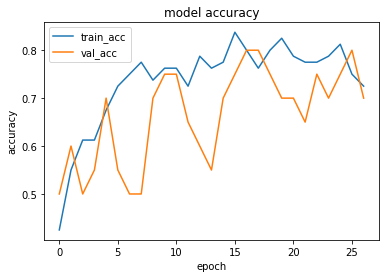

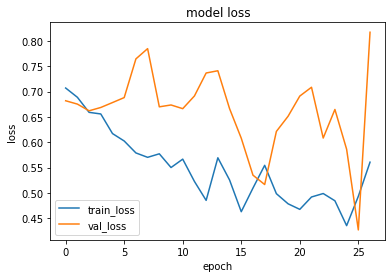

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.60021186]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.8363066]]


1it [00:00, 9000.65it/s]


prediction for video armflapping_2.mov is [[0.7554003]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.29509857]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.2559536]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.25784937]]
Epoch 1/75
3/3 [==============================] - 1s 284ms/step - loss: 0.7088 - accuracy: 0.4125 - precision_190: 0.4565 - recall_190: 0.4884 - val_loss: 0.7051 - val_accuracy: 0.4000 - val_precision_190: 0.3529 - val_recall_190: 0.8571
Epoch 2/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6697 - accuracy: 0.6000 - precision_190: 0.5733 - recall_190: 1.0000 - val_loss: 0.7032 - val_accuracy: 0.4000 - val_precision_190: 0.3333 - val_recall_190: 0.7143
Epoch 3/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6265 - accuracy: 0.6500 - precision_190: 0.6119 - recall_190: 0.9535 - val_loss: 0.7504 - val_accuracy: 0.4000 - val_precision_190: 0.3333 - val_recall_190: 0.7143
Epoch 4/75
3/3 [==============================] - 1s 292ms/step - loss: 0.5718 - accuracy: 0.6625 - precision_190: 0.6212 - recall_190: 0.9535 - val_loss: 0.7139 - val_accuracy: 0.7000 - val_precision_190: 0.5714 - val_recall_190: 0.

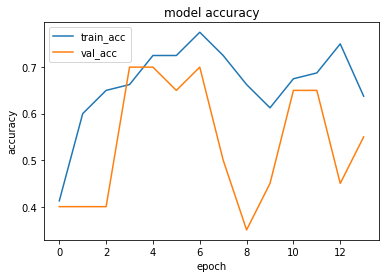

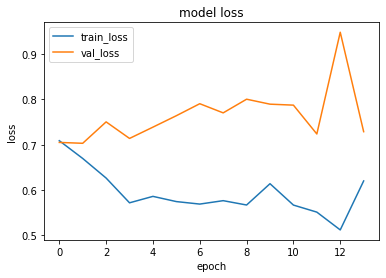

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.66841793]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.71491796]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.735683]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.52635854]]


1it [00:00, 12826.62it/s]


prediction for video control_2.mov is [[0.4230329]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.51875097]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.7000 - accuracy: 0.4125 - precision_191: 0.4426 - recall_191: 0.6750 - val_loss: 0.6778 - val_accuracy: 0.5000 - val_precision_191: 0.5000 - val_recall_191: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 280ms/step - loss: 0.6621 - accuracy: 0.5750 - precision_191: 0.5441 - recall_191: 0.9250 - val_loss: 0.6549 - val_accuracy: 0.5000 - val_precision_191: 0.5000 - val_recall_191: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6311 - accuracy: 0.6625 - precision_191: 0.6182 - recall_191: 0.8500 - val_loss: 0.6445 - val_accuracy: 0.6500 - val_precision_191: 0.5882 - val_recall_191: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 278ms/step - loss: 0.6208 - accuracy: 0.6875 - precision_191: 0.6667 - recall_191: 0.7500 - val_loss: 0.6237 - val_accuracy: 0.6500 - val_precision_191: 0.5882 - val_recall_191: 1.

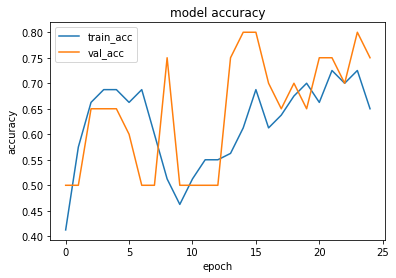

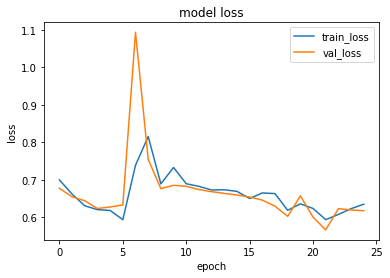

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.46663803]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.41179213]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.4903003]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.42392558]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.40025228]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.3925288]]


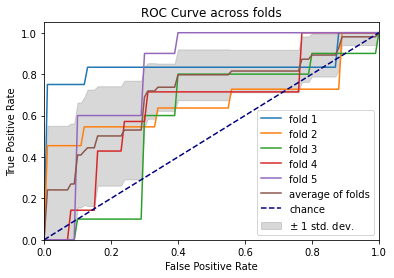

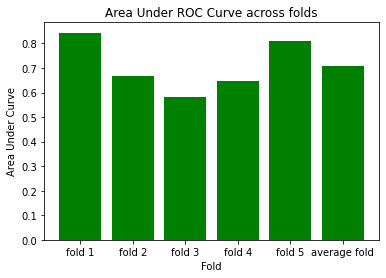

In [48]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

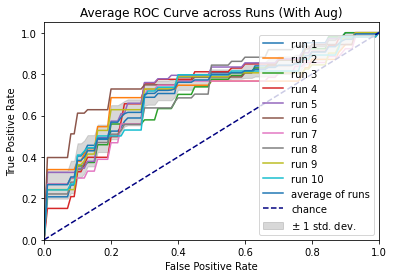

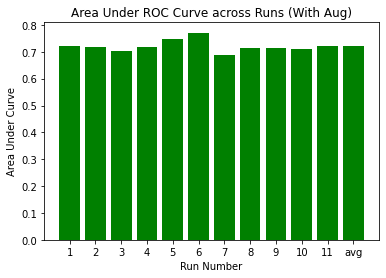

In [52]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1,101))

In [54]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7206123765123764, 0.020083418293332454)